# Ames Housing Modeling

# Step 1:  Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt
from tabulate import tabulate

# Step 2:  Load the Data

In [2]:
housing_data = pd.read_csv('housing_data_cleaned.csv')

# Step 3: Impute Values

In [3]:
fill_mean = ['Lot Frontage', 'Lot Area', 'Gr Liv Area']

In [4]:
fill_mode = ['PID', 'MS SubClass', 'MS Zoning', 'Lot Shape', 'Land Contour', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Exterior 1st', 'Exterior 2nd',
       'Mas Vnr Type', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation',   'Electrical', 'Full Bath',
       'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual','Functional',  'Yr Sold']

#### note.  I am not imputing values regarding things like basement, pool, garage, air conditioning etc which may not be present .  

In [5]:
for item in fill_mean:
    housing_data[item].fillna(housing_data[item].mean(), inplace = True)

In [6]:
for thing in fill_mode:
    housing_data[thing].fillna(housing_data[thing].mode(), inplace = True)

# Step 4: Create Dummy Variables

#### If you recall from our EDA, our data had quite a few 'object' variables.  Here we are going to create Dummy Variables so we can analyze both our numeric and our object variables

In [7]:
housing_data.head()
housing_data.shape

(2930, 78)

In [8]:
df = pd.get_dummies(housing_data, drop_first = True)
df = df.dropna()
df = df.drop(columns=['Order'])
df = df.drop(columns = ['Overall Qual'])
df.shape


(2747, 244)

# Step 5:  Addressing Multi-Colinearity

In [9]:
###  These functions were adopted from an answer to a question on stack overflow
### We are looking at high correlations 
### with the idea that we can eliminate variables that have extremely high correlation with another variable

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 9))

Top Absolute Correlations
Sale Type_New         Sale Condition_Partial    0.985696
Exterior 1st_CemntBd  Exterior 2nd_CmentBd      0.980893
Exterior 1st_VinylSd  Exterior 2nd_VinylSd      0.978538
Exterior 1st_MetalSd  Exterior 2nd_MetalSd      0.972056
Roof Style_Gable      Roof Style_Hip            0.945156
Exter Qual_Gd         Exter Qual_TA             0.906449
Exter Cond_Gd         Exter Cond_TA             0.896934
Exterior 1st_HdBoard  Exterior 2nd_HdBoard      0.891455
Garage Qual_Fa        Garage Qual_TA            0.886101
dtype: float64


In [10]:
#  It looks like there is a high (> .95) correlation betweeen a few of our variables.
#  With that we are safe to drop the following variables:
#  Sale  Contidion_Partial, Exterior 2nd_CmentD, Exterior 2nd_VinlySd, and Exterior 2nd_MetalSd
# Lets go ahead and do that!

In [11]:
df = df.drop(columns=['Sale Condition_Partial', 'Exterior 2nd_CmentBd', 'Exterior 2nd_VinylSd', 'Exterior 2nd_MetalSd'])

In [12]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 9))

Top Absolute Correlations
Roof Style_Gable      Roof Style_Hip          0.945156
Exter Qual_Gd         Exter Qual_TA           0.906449
Exter Cond_Gd         Exter Cond_TA           0.896934
Exterior 1st_HdBoard  Exterior 2nd_HdBoard    0.891455
Garage Qual_Fa        Garage Qual_TA          0.886101
MS Zoning_FV          Neighborhood_Somerst    0.869312
Exterior 1st_Wd Sdng  Exterior 2nd_Wd Sdng    0.868191
Garage Cars           Garage Area             0.845252
Year Built            Garage Yr Blt           0.842375
dtype: float64


In [13]:
#  Now that we have addressed our high correlations, we can look at the multicolinearity in more detail using VIF. 

In [14]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [15]:

features = df.drop(columns=['SalePrice'])

X = add_constant(features)
vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
vif = vif.sort_values(ascending=False)
vif = vif.round(2)

print(vif.head(59))


C:\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


BsmtFin SF 2                   inf
Gr Liv Area                    inf
Low Qual Fin SF                inf
2nd Flr SF                     inf
1st Flr SF                     inf
Total Bsmt SF                  inf
Bsmt Unf SF                    inf
BsmtFin SF 1                   inf
const                   2833808.89
MS Zoning_RL               1928.48
MS Zoning_RM               1458.30
MS Zoning_FV                535.76
Garage Qual_TA              108.05
MS Zoning_RH                 93.68
Garage Qual_Fa               88.95
Garage Cond_TA               70.71
MS Zoning_C (all)            64.65
Garage Cond_Fa               51.54
Roof Style_Gable             44.67
Roof Style_Hip               42.66
Garage Type_Attchd           36.03
Mas Vnr Type_None            34.99
Exter Cond_TA                31.94
Garage Type_Detchd           31.30
Mas Vnr Type_BrkFace         30.78
MS SubClass                  27.82
Exterior 1st_HdBoard         27.51
Exter Cond_Gd                27.26
Exterior 1st_VinylSd

#####  Ok I am going to take these VIF scores by groupings.  We see a handful of variables with a variety of square foot measurements.  Going back to our Feature Importance, one of our most important Features were Gr Liv Area ,BsmtFin SF 1, and Total Bsmt Sq Ft.  So we want to keep these variables and remove some other variables that are telling us the same information. 

In [16]:
df = df.drop(columns=['BsmtFin SF 2', 'Low Qual Fin SF', '2nd Flr SF', '1st Flr SF', 'Bsmt Unf SF'])

##### OK. Next lets tackle the zoning variables.  None of these variables were identified as particularly important in our feature importance so I am going to remove indiscriminantly.  

In [17]:
df = df.drop(columns=['MS Zoning_RL', 'MS Zoning_RM', 'MS Zoning_FV', 'MS Zoning_RH', 'MS Zoning_C (all)', 'MS Zoning_I (all)'])

#####  Next we will try to identify area where there are two or more variables basically saying the opposite of each other ie condition fair or good and eliminate one of these

In [18]:
df = df.drop(columns =['Garage Qual_TA', 'Garage Qual_Fa', 'Garage Cond_TA', 'Roof Style_Hip', 'Mas Vnr Type_None', 'Exter Cond_TA', 'Garage Type_Detchd',
'MS SubClass', 'Exter Cond_Gd', 'Exterior 1st_VinylSd', 'Bsmt Cond_TA', 'Exterior 1st_Wd Sdng', 'Garage Qual_Gd', 'Exterior 1st_Plywood'   ,
'Exterior 2nd_HdBoard', 'Functional_Typ', 'Mas Vnr Type_Stone', 'House Style_1Story', 'BsmtFin Type 2_Unf', 'Garage Cond_Gd',
'Neighborhood_Edwards', 'Exterior 2nd_Wd Sdng', 'Garage Type_BuiltIn', 'Exterior 1st_CBlock', 'Bsmt Qual_TA', 'Kitchen Qual_TA'])


In [19]:

features = df.drop(columns=['SalePrice'])

X = add_constant(features)
vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
vif = vif.sort_values(ascending=False)
vif = vif.round(2)

print(vif.head(19))

const                 2735205.09
Exter Qual_TA              15.07
Year Built                 13.03
Exter Qual_Gd              11.73
Gr Liv Area                 9.19
Condition 2_Norm            8.55
Foundation_PConc            7.63
PID                         7.53
Neighborhood_NAmes          6.87
Foundation_CBlock           6.21
Pool Area                   6.00
Garage Yr Blt               5.63
Fireplaces                  5.43
Garage Cars                 5.19
Condition 1_Norm            5.19
Garage Area                 5.14
Total Bsmt SF               4.99
Sale Type_WD                4.96
TotRms AbvGrd               4.95
dtype: float64


##### This is interesting.  We got rid of the 'zoning' variables and it looks like that resulted in reduced multicolinearity with neighorhood variables
With this done, lets look at the remaining variables

In [20]:
df = df.drop(columns=['Exter Qual_Gd', 'Foundation_PConc', 'Garage Yr Blt', 'Year Remod/Add'])

In [21]:
features = df.drop(columns=['SalePrice'])

X = add_constant(features)
vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
vif = vif.sort_values(ascending=False)
vif = vif.round(2)

print(vif.head(9))

const                 2714183.67
Year Built                  9.98
Gr Liv Area                 9.18
Condition 2_Norm            8.54
PID                         7.52
Neighborhood_NAmes          6.86
Pool Area                   5.98
Fireplaces                  5.41
Condition 1_Norm            5.19
dtype: float64


###### ok.  this is good we have eliminated enough variables to keep our VIF below 10 for each remaining variable and have kept our important variables as indicated in our feature importance.

In [22]:
df.head()

,PID,Lot Frontage,Lot Area,Overall Cond,Year Built,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,Gr Liv Area,Bsmt Full Bath,...,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal
0,526301100,141.0,31770,5,1960,112.0,639.0,1080.0,1656,1.0,...,0,0,0,0,0,1,0,0,0,1
1,526350040,80.0,11622,6,1961,0.0,468.0,882.0,896,0.0,...,0,0,0,0,0,1,0,0,0,1
2,526351010,81.0,14267,6,1958,108.0,923.0,1329.0,1329,0.0,...,0,0,0,0,0,1,0,0,0,1
3,526353030,93.0,11160,5,1968,0.0,1065.0,2110.0,2110,1.0,...,0,0,0,0,0,1,0,0,0,1
4,527105010,74.0,13830,5,1997,0.0,791.0,928.0,1629,0.0,...,0,0,0,0,0,1,0,0,0,1


# Step 5:  Linear Regression Feature Coeficients


### Step 5 part A:  Evaluate Coefficients WITHOUT scaling (not the best)

In [23]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [24]:
 
y = df[['SalePrice']]
X = df.drop(columns=['SalePrice'])
results = sm.OLS(y, X).fit()

coefs = results.params
coefs = abs(coefs)
coefs.sort_values(ascending=False).head(15)

Pool QC_Gd              331994.124866
Pool QC_Fa              188326.499476
Pool QC_TA              158684.213611
Neighborhood_GrnHill    136051.193859
Mas Vnr Type_CBlock      91966.406850
Condition 2_PosA         90250.131444
Condition 2_PosN         73622.193755
Electrical_Mix           70502.849164
Neighborhood_StoneBr     68781.758793
Functional_Sev           59258.113277
Neighborhood_NridgHt     57973.372031
Neighborhood_NoRidge     49166.481241
Kitchen Qual_Po          46818.007168
Neighborhood_NPkVill     44535.190087
Exterior 2nd_Other       39625.581074
dtype: float64

##### Ok here we see a list of features with the highest coefficients.  They are not scaled so some features may have outsized impact on our model compared to if they had been scaled.

### Step 5 part B:  Evaluate Coefficients WITH scaling (better)

In [25]:
scaler = RobustScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)
scaled_features_df = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)

In [26]:
#note I am not scaling the dependent variable
y = df[['SalePrice']]
X = scaled_features_df.drop(columns=['SalePrice'])
results = sm.OLS(y, X).fit()
#print(results.summary())
coefs = results.params
coefs = abs(coefs)


##### Ok.  Well this is fascinating.  We have scaled our data and extracted the coefficients from an ordinary least squares regression.  Given the data is standardized the coefficients should be a reflection of the relative impact of the feature on the sales price.  What is interesting is that we do NOT see the same features as important when we compare this list to the list of important variables generated from the Random Forest Feature Importance we did earlier. 

In [27]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              495.5
Date:                Sun, 19 Jun 2022   Prob (F-statistic):                        0.00
Time:                        23:07:39   Log-Likelihood:                         -32416.
No. Observations:                2747   AIC:                                  6.522e+04
Df Residuals:                    2552   BIC:                                  6.638e+04
Df Model:                         195                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [28]:
y_pred = results.fittedvalues

Text(0.5, 1.0, 'Relationship between predicted and actual Price')

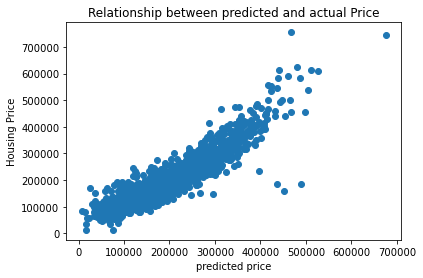

In [29]:
plt.scatter(y_pred, y)
plt.xlabel("predicted price")
plt.ylabel("Housing Price")
plt.title("Relationship between predicted and actual Price")

In [30]:
coefs = pd.DataFrame(coefs)

In [31]:
results.bse
std_err = pd.DataFrame(results.bse)

In [32]:
matrix = pd.concat([coefs, coefs, std_err], axis = 1)
matrix.columns = ['One', 'Coefs', 'BSE']
matrix.head(3)

,One,Coefs,BSE
PID,47193.985920,47193.985920,3087.197760
Lot Frontage,1162.696768,1162.696768,863.905472
Lot Area,1945.079333,1945.079333,501.949741


In [33]:
matrix = matrix.sort_values(by = 'Coefs', ascending = False)
matrix = matrix.head(20)

C:\Users\BETH&A~1\AppData\Local\Temp/ipykernel_4660/3007281566.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(matrix.index, rotation = 90)


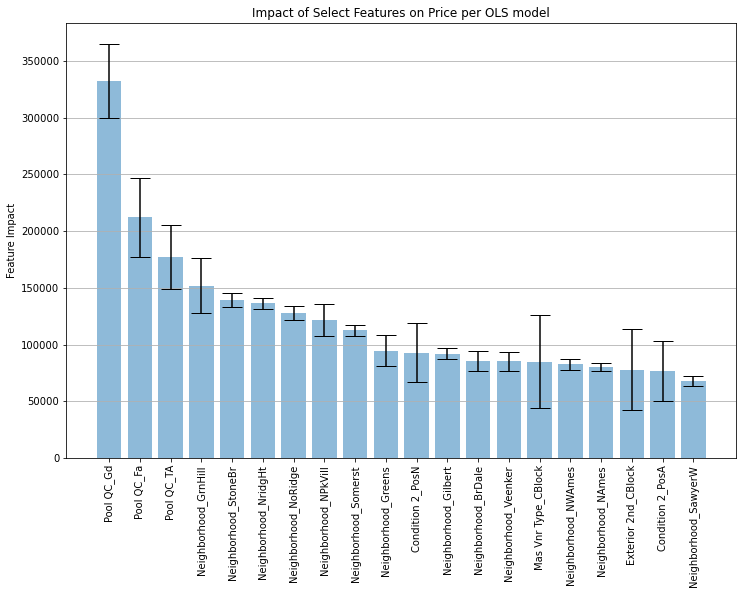

In [34]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
ax.bar(matrix.index, matrix['Coefs'], yerr=matrix['BSE'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Feature Impact')
ax.set_title('Impact of Select Features on Price per OLS model')
ax.yaxis.grid(True)
ax.set_xticklabels(matrix.index, rotation = 90)
#plt.tight_layout()

plt.show()

#### The above graph should represent the top 20 features in terms of their importance in predicting the Sales Price. These are not consistent with what we saw previously with the Random Forest Feature Importance.  Nor do they seem logically like the best variables.  I think we should look at a second method SHAP importance to see how that shakes out.

# Step 6:  SHAP Feature Importance

In [35]:
import shap
from xgboost.sklearn import XGBRegressor

In [36]:
model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
y = df[['SalePrice']]
X = scaled_features_df.drop(columns=['SalePrice'])
# Fit the Model
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


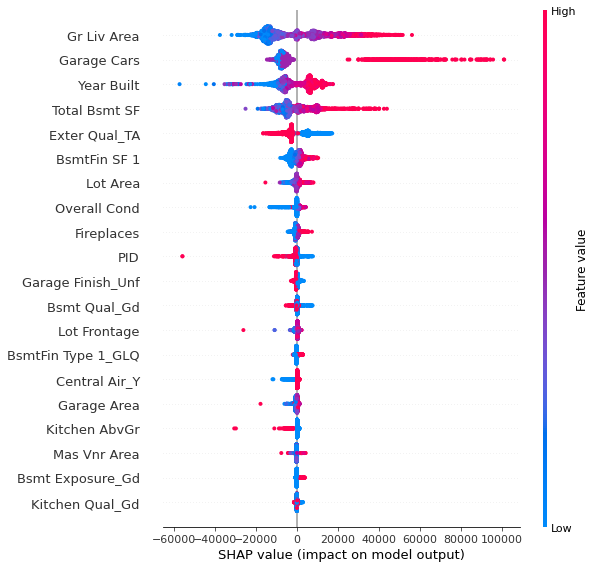

In [37]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, features=X, feature_names=X.columns)

In [38]:
key_features = ['Gr Liv Area', 'Garage Cars', 'Year Built', 'Total Bsmt SF', 'Exter Qual_TA', 'BsmtFin SF 1', 'Lot Area', 'Overall Cond', 'PID', 'Fireplaces', 'Bsmt Qual_Gd', 'Garage Area', 'Garage Finish_Unf', 'Lot Frontage', 'Mas Vnr Area', 'Open Porch SF', 'Fireplace Qu_Gd', 'Wood Deck SF', 'Central Air_Y', 'Bsmt Exposure_Gd']


In [39]:
##### Note here:  These features seem more consistent with the Random Forest Feature Importance that we did earlier. 

# Step 7: Train - Test Split

In [40]:
df_y = df[['SalePrice']]
df_y.shape

(2747, 1)

In [41]:
df_X = scaled_features_df.drop(columns=['SalePrice'])
df_X.shape

(2747, 198)

In [42]:
X = df_X
y = df_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

#  Step 8: First Model is Random Forest

#### We are just starting with a random forest model on our scaled data. 

In [43]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor()

In [44]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [45]:
r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

(0.9819580112216354, 0.8610619671188334)

In [46]:
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)

(6352.134012482663, 17920.51272613849)

In [47]:
from math import sqrt
sqrt(mean_squared_error(y_train, y_train_pred)), sqrt(mean_squared_error(y_test, y_test_pred))

(10642.311183861573, 29902.105555520608)

##### We can try to use a Grid Search to improve our Random Forest Regression to see the optimal number of n_estimators

In [48]:
from sklearn.ensemble import RandomForestRegressor
n_est = [int(n) for n in np.logspace(start=1, stop=3, num=20)]
param_grid = {'n_estimators': n_est}
rf1 = RandomForestRegressor(random_state = 1519)
rf_cv = GridSearchCV(rf1, param_grid, cv = 5)
rf_cv.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1519),
             param_grid={'n_estimators': [10, 12, 16, 20, 26, 33, 42, 54, 69,
                                          88, 112, 143, 183, 233, 297, 379, 483,
                                          615, 784, 1000]})

In [49]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.8719326371350888
Best Parameters: {'n_estimators': 784}


##### The grid search suggested the best hyperparameter is n_estimator of 784  Therefore I will try again with n_estimators equal to 784 and see what happens.

In [52]:
rf = RandomForestRegressor(n_estimators=784)
rf.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestRegressor(n_estimators=784)

In [53]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [54]:
r2_score_train_rf = r2_score(y_train, y_train_pred)
r2_score_test_rf = r2_score(y_test, y_test_pred)
r2_score_train_rf, r2_score_test_rf

(0.9831962284913838, 0.8613399818224067)

In [55]:
MAE_train_rf = mean_absolute_error(y_train, y_train_pred)
MAE_test_rf = mean_absolute_error(y_test, y_test_pred)
MAE_train_rf, MAE_test_rf

(6178.228027788786, 17887.460197397737)

In [56]:
from math import sqrt
rmse_train_rf = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_rf = sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train_rf, rmse_test_rf

(10270.631163988803, 29872.173550251606)

Text(0.5, 1.0, 'Relationship between predicted and actual Price of Training Set')

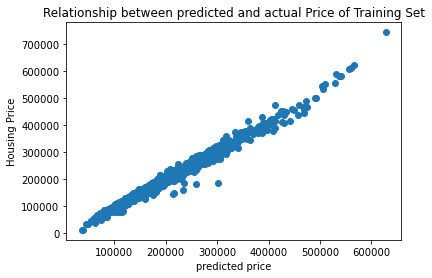

In [57]:
plt.scatter(y_train_pred, y_train)
plt.xlabel("predicted price")
plt.ylabel("Housing Price")
plt.title("Relationship between predicted and actual Price of Training Set")

##### This is not much of an improvement from n_est = 100, but it is a robust model we can compare to other models


In [58]:
# lets just summarize our findings from Random Forest model
from tabulate import tabulate
d = [ ["r2 Score Train", r2_score_train_rf], ["r2 Score Test", r2_score_test_rf], ["Mean Absolute Error (MAE) Train", MAE_train_rf],
    ["Mean Absolute Error(MAE) Test", MAE_test_rf], ["Root Mean Square Error (RMSE) Train", rmse_train_rf], ["Root Mean Square Error (RMSE) Test", rmse_test_rf]]

print(tabulate(d, headers=["Random Forest Evaluation Metrics", "Metric"]))

Random Forest Evaluation Metrics           Metric
-----------------------------------  ------------
r2 Score Train                           0.983196
r2 Score Test                            0.86134
Mean Absolute Error (MAE) Train       6178.23
Mean Absolute Error(MAE) Test        17887.5
Root Mean Square Error (RMSE) Train  10270.6
Root Mean Square Error (RMSE) Test   29872.2


# Step 9: Second Model is Ridge Regression

##### Ridge Regression is useful when there is still  some multicolinearity among variables.  We will go ahead and use it here for our real estate model.

In [59]:
from sklearn.linear_model import Ridge

In [60]:
ridge = Ridge(alpha = 1)
ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [61]:
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [62]:
r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

(0.8888101247352804, 0.8824299447327424)

In [63]:
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)


(17033.85094579416, 18283.62976919664)

In [64]:
sqrt(mean_squared_error(y_train, y_train_pred)), sqrt(mean_squared_error(y_test, y_test_pred))


(26419.608090625476, 27506.76762235471)

##### The initial model does not perform as well as the Random Forest so lets see if we can improve this by adjusting our hyperparameters.

In [65]:
n_est = [int(n) for n in np.logspace(start=0, stop=3, num=30)]
param_grid = {'alpha':n_est}
ridge = Ridge()
ridge_cv= GridSearchCV(ridge,param_grid,cv=5)
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1, 1, 1, 2, 2, 3, 4, 5, 6, 8, 10, 13, 17, 22,
                                   28, 35, 45, 57, 72, 92, 117, 148, 188, 239,
                                   303, 385, 489, 621, 788, 1000]})

In [66]:
print("Best Score:" + str(ridge_cv.best_score_))
print("Best Parameters: " + str(ridge_cv.best_params_))

Best Score:0.7954374447135271
Best Parameters: {'alpha': 6}


#####  Ok our grid search indicated a much higher alpha so lets revisit with this higher alpha

In [67]:
ridge = Ridge(alpha = 6)
ridge.fit(X_train, y_train)

Ridge(alpha=6)

In [68]:
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [69]:
r2_score_train_ridge = r2_score(y_train, y_train_pred)
r2_score_test_ridge = r2_score(y_test, y_test_pred)
r2_score_train_ridge, r2_score_test_ridge 

(0.8798255906175709, 0.8829770584813794)

In [70]:
MAE_train_ridge = mean_absolute_error(y_train, y_train_pred)
MAE_test_ridge = mean_absolute_error(y_test, y_test_pred)
MAE_train_ridge, MAE_test_ridge

(17309.22082550729, 18166.598099278013)

In [71]:
rmse_train_ridge = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_ridge = sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train_ridge, rmse_test_ridge

(27466.27396581779, 27442.691443979973)

In [72]:
### This seems like a modest improvement from our initial model. 

Text(0.5, 1.0, 'Relationship between predicted and actual Price of Training Set')

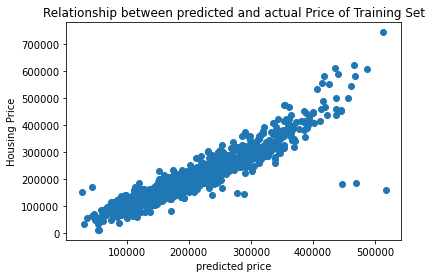

In [73]:
plt.scatter(y_train_pred, y_train)
plt.xlabel("predicted price")
plt.ylabel("Housing Price")
plt.title("Relationship between predicted and actual Price of Training Set")

Text(0.5, 1.0, 'Predicted Values vs Residuals of Training Set')

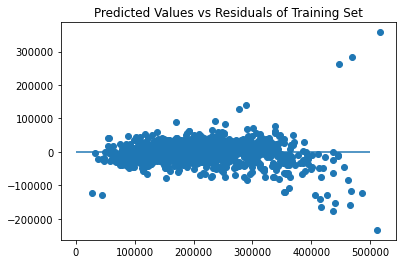

In [74]:
plt.scatter(y_train_pred, (y_train_pred - y_train))
plt.hlines(y=0, xmin = 0, xmax = 500000)
plt.title("Predicted Values vs Residuals of Training Set")

Text(0.5, 1.0, 'Predicted Values vs Residuals of Training Set')

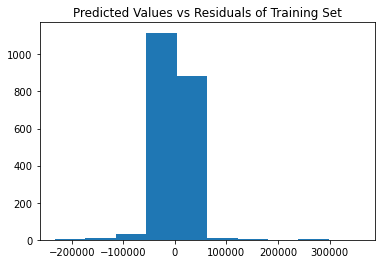

In [75]:
plt.hist(y_train_pred - y_train, bins = 10)
plt.title("Predicted Values vs Residuals of Training Set")

In [76]:
# lets just summarize our findings from Ridge Regression 
from tabulate import tabulate
d = [ ["r2 Score Train", r2_score_train_ridge], ["r2 Score Test", r2_score_test_ridge], ["Mean Absolute Error (MAE) Train", MAE_train_ridge],
    ["Mean Absolute Error(MAE) Test", MAE_test_ridge], ["Root Mean Square Error (RMSE) Train", rmse_train_ridge], ["Root Mean Square Error (RMSE) Test", rmse_test_ridge]]

print(tabulate(d, headers=["Ridge Regression Evaluation Metrics", "Metric"]))

Ridge Regression Evaluation Metrics          Metric
-------------------------------------  ------------
r2 Score Train                             0.879826
r2 Score Test                              0.882977
Mean Absolute Error (MAE) Train        17309.2
Mean Absolute Error(MAE) Test          18166.6
Root Mean Square Error (RMSE) Train    27466.3
Root Mean Square Error (RMSE) Test     27442.7


# Step 9: Third Model is Linear Regression

In [77]:
lm = LinearRegression().fit(X_train, y_train)

In [78]:
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)

In [79]:
r2_score_train_lm = r2_score(y_train, y_train_pred)
r2_score_test_lm = r2_score(y_test, y_test_pred)
r2_score_train_lm, r2_score_test_lm

(0.8927714863897984, 0.8834806244192737)

In [80]:
MAE_train_lm = mean_absolute_error(y_train, y_train_pred)
MAE_test_lm = mean_absolute_error(y_test, y_test_pred)
MAE_train_lm, MAE_test_lm

(16841.535249403307, 18177.647340629206)

In [81]:
rmse_train_lm = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_lm = sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train_lm, rmse_test_lm

(25944.714285445007, 27383.582934842165)

Text(0.5, 1.0, 'Relationship between predicted and actual Price of Training Set')

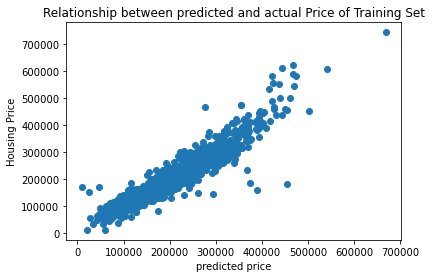

In [82]:
plt.scatter(y_train_pred, y_train)
plt.xlabel("predicted price")
plt.ylabel("Housing Price")
plt.title("Relationship between predicted and actual Price of Training Set")

Text(0.5, 1.0, 'Predicted Values vs Residuals of Training Set')

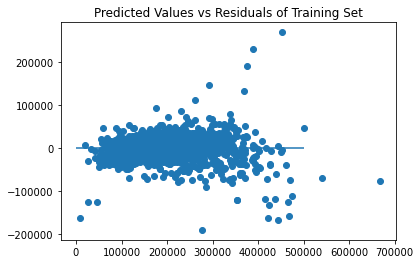

In [83]:
plt.scatter(y_train_pred, (y_train_pred - y_train))
plt.hlines(y=0, xmin = 0, xmax = 500000)
plt.title("Predicted Values vs Residuals of Training Set")

Text(0.5, 1.0, 'Predicted Values vs Residuals of Training Set')

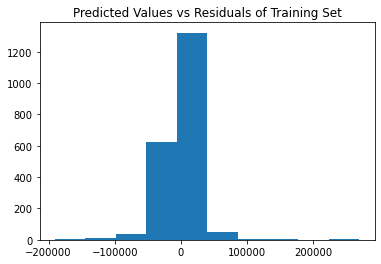

In [84]:
plt.hist(y_train_pred - y_train, bins = 10)
plt.title("Predicted Values vs Residuals of Training Set")

In [85]:
##### Lets see if we can improve upon this result by limiting our variables

In [86]:
df_y = df[['SalePrice']]
df_X = scaled_features_df[key_features]


In [87]:

X_train_prime, X_test_prime, y_train_prime, y_test_prime = train_test_split(df_X, df_y, test_size=0.25, random_state=12)

In [88]:
lm = LinearRegression().fit(X_train_prime, y_train_prime)

In [89]:
y_train_pred_prime = lm.predict(X_train_prime)
y_test_pred_prime = lm.predict(X_test_prime)

In [90]:
r2_score(y_train_prime, y_train_pred_prime), r2_score(y_test_prime, y_test_pred_prime)

(0.7896651159156057, 0.8289214922385626)

In [91]:
mean_absolute_error(y_train_prime, y_train_pred_prime), mean_absolute_error(y_test_prime, y_test_pred_prime)

(22687.08238072378, 22533.772460033284)

In [92]:
sqrt(mean_squared_error(y_train_prime, y_train_pred_prime)), sqrt(mean_squared_error(y_test_prime, y_test_pred_prime))

(36337.027930759, 33180.95825033062)

#####  When we limit the features the predictive power of our model declines and our rmse increases so we will report the results of our original model in the summary below

In [93]:
# lets summarize our data for plain vanilla linear regression
d = [ ["r2 Score Train", r2_score_train_lm], ["r2 Score Test", r2_score_test_lm], ["Mean Absolute Error (MAE) Train", MAE_train_lm],
    ["Mean Absolute Error(MAE) Test", MAE_test_lm], ["Root Mean Square Error (RMSE) Train", rmse_train_lm], ["Root Mean Square Error (RMSE) Test", rmse_test_lm]]

print(tabulate(d, headers=["Linear Regression Evaluation Metrics", "Metric"]))

Linear Regression Evaluation Metrics          Metric
--------------------------------------  ------------
r2 Score Train                              0.892771
r2 Score Test                               0.883481
Mean Absolute Error (MAE) Train         16841.5
Mean Absolute Error(MAE) Test           18177.6
Root Mean Square Error (RMSE) Train     25944.7
Root Mean Square Error (RMSE) Test      27383.6


##### So our results are not meaningfully different from the ridge regression.  Therefore lets do one final model.

# Step 9: Fourth Model is Gradient Boosting

In [94]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingRegressor()

In [95]:
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

In [96]:
r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)

(0.955194084017098, 0.8939536174809101)

In [97]:
mean_absolute_error(y_train, y_train_pred), mean_absolute_error(y_test, y_test_pred)

(12262.237437234682, 17306.067138844457)

In [98]:
sqrt(mean_squared_error(y_train, y_train_pred)), sqrt(mean_squared_error(y_test, y_test_pred))

(16771.09540746859, 26123.967002919842)

In [99]:
### Once again we can try to optimize our hyperparameters.  This time the learning rate.

In [100]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
param_grid = {'learning_rate':learning_rates}
gb = GradientBoostingRegressor()
gb_cv= GridSearchCV(gb,param_grid,cv=5)
gb_cv.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1]})

In [101]:
print("Best Score:" + str(gb_cv.best_score_))
print("Best Parameters: " + str(gb_cv.best_params_))

Best Score:0.8842811647190736
Best Parameters: {'learning_rate': 0.1}


In [102]:
gb = GradientBoostingRegressor(learning_rate = 0.1)
gb.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingRegressor()

In [103]:
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

In [104]:
r2_score_train_gb = r2_score(y_train, y_train_pred)
r2_score_test_gb = r2_score(y_test, y_test_pred)
r2_score_train_gb, r2_score_test_gb

(0.955194084017098, 0.8922261070744023)

In [105]:
MAE_train_gb = mean_absolute_error(y_train, y_train_pred)
MAE_test_gb = mean_absolute_error(y_test, y_test_pred)
MAE_train_gb, MAE_test_gb

(12262.23743723468, 17358.292413238665)

In [106]:
rmse_train_gb = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_gb = sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train_gb, rmse_test_gb

(16771.09540746859, 26335.88896833832)

Text(0.5, 1.0, 'Relationship between predicted and actual Price of Training Set')

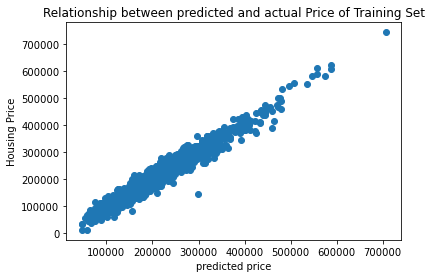

In [107]:
plt.scatter(y_train_pred, y_train)
plt.xlabel("predicted price")
plt.ylabel("Housing Price")
plt.title("Relationship between predicted and actual Price of Training Set")

In [108]:
# lets summarize our data for gradient boosting
d = [ ["r2 Score Train", r2_score_train_gb], ["r2 Score Test", r2_score_test_gb], ["Mean Absolute Error (MAE) Train", MAE_train_gb],
    ["Mean Absolute Error(MAE) Test", MAE_test_gb], ["Root Mean Square Error (RMSE) Train", rmse_train_gb], ["Root Mean Square Error (RMSE) Test", rmse_test_gb]]

print(tabulate(d, headers=["Gradient Boosting Evaluation Metrics", "Metric"]))

Gradient Boosting Evaluation Metrics          Metric
--------------------------------------  ------------
r2 Score Train                              0.955194
r2 Score Test                               0.892226
Mean Absolute Error (MAE) Train         12262.2
Mean Absolute Error(MAE) Test           17358.3
Root Mean Square Error (RMSE) Train     16771.1
Root Mean Square Error (RMSE) Test      26335.9


# Step 10:  Comparing Our Models

In this notebook I have used four different regression algorithms to model the Ames, Iowa housing data with the objective of finding the best model to predect a dependent variable (Sales Price) based on the features of the property.  

For each model, I used a grid search cross-validation to optimize the hyperparameters.  For our normal Linear Regression Model, no hyperparameter optimization was available, so I reduced the number of variables to just our top twenty variables as identified by our SHAP feature importance.  

The table below outlines which hyperparameters were optimized for each model as well as the optimal hyperparameters as indicated by our grid search.



In [109]:
d = [ ["Random Forest",r2_score_test_rf, "n_estimators", "n_estimators = 483"], ["Ridge Regression", r2_score_test_ridge, "Alpha", "Alpha = 6"], ["Linear Regression",r2_score_test_lm, "Number of Variables", "Include All Variables"],
    ["Gradient Boosting",r2_score_test_gb, "Learning Rate", "Learning Rate = 0,1"]]
print(" ")
print(" ")
print(tabulate(d, headers=["   Model  ", "r2 Score (Test-Data)", "Hyperparameter To Optimize", "Optimal Hyperparameter"]))
print("")

 
 
   Model             r2 Score (Test-Data)  Hyperparameter To Optimize    Optimal Hyperparameter
-----------------  ----------------------  ----------------------------  ------------------------
Random Forest                    0.86134   n_estimators                  n_estimators = 483
Ridge Regression                 0.882977  Alpha                         Alpha = 6
Linear Regression                0.883481  Number of Variables           Include All Variables
Gradient Boosting                0.892226  Learning Rate                 Learning Rate = 0,1



One metric we will examine is the R-squared which is the extent to which the variance in the independent variables influences the variance in our dependent variable.  This is referred to as the Goodness of Fit as it is an indication of how well the data fits the regression model.  So the higher R-squared will indicate a model that creates a better fit of our data.  
Of our models, the two decision tree models (Gradient Boosting and Random Forest) give us the best R-Squared on the training data, and all of the models perform similarly on the test data.

The other metric we might focus on is the Root Mean Square Error (RMSE) which is a measure of how far our predictions fall from our actual Sales Price.  The Root Mean Squared Error is in the same units as our Dependent Variable (USD) and is therfore a usefull measure.  It is our objective to minimize RMSE.  Here our decision tree based models perform better than our two other models.  


In [110]:
d = [ ["r2 Score Train",r2_score_train_rf, r2_score_train_ridge, r2_score_train_lm, r2_score_train_gb], ["r2 Score Test", r2_score_test_rf, r2_score_test_ridge, r2_score_test_lm, r2_score_test_gb], ["Mean Absolute Error (MAE) Train",MAE_train_rf, MAE_train_ridge, MAE_train_lm, MAE_train_gb],
    ["Mean Absolute Error(MAE) Test",MAE_test_rf, MAE_test_ridge, MAE_test_lm, MAE_test_gb], ["Root Mean Square Error (RMSE) Train",rmse_train_rf, rmse_train_ridge, rmse_train_lm, rmse_train_gb], ["Root Mean Square Error (RMSE) Test",rmse_test_rf, rmse_test_ridge, rmse_test_lm, rmse_test_gb]]
print("")
print(tabulate(d, headers=["   Evaluation Metric  ", "Random Forest", "Ridge Regression", "Linear Regression", "Gradient Boosting"]))


   Evaluation Metric                   Random Forest    Ridge Regression    Linear Regression    Gradient Boosting
-----------------------------------  ---------------  ------------------  -------------------  -------------------
r2 Score Train                              0.983196            0.879826             0.892771             0.955194
r2 Score Test                               0.86134             0.882977             0.883481             0.892226
Mean Absolute Error (MAE) Train          6178.23            17309.2              16841.5              12262.2
Mean Absolute Error(MAE) Test           17887.5             18166.6              18177.6              17358.3
Root Mean Square Error (RMSE) Train     10270.6             27466.3              25944.7              16771.1
Root Mean Square Error (RMSE) Test      29872.2             27442.7              27383.6              26335.9


Between the Random Forest and the Gradient Boosting Models, I prefer the Gradient Boosting model.  
This model does not perform as well as the Random Forest on the Training Set but performs better thatn the Random Forest both in the R-Squared and the RMSE when looking at the Test Data.  Based on this it is possible the Random Forest is overfitting to the training set.  

The purpose of our model is to determine the price of a real estate offering where the sales price is unknown.  
Given the superior performance on the training data I would expect the Gradinet Boosting Regressor to perform the best on a new data set.  

Therefore I would recommend using the Gradient Boosting Model on this dataset.  



# Step 11:  Use a model to predict sales price on a test case 

In [111]:
X_bm = X_test.iloc[25, :]

X_bm.shape

(198,)

In [112]:
X_train.shape

(2060, 198)

In [113]:
X_bm = X_bm.transpose
X_bm

<bound method IndexOpsMixin.transpose of PID                      -0.002638
Lot Frontage              0.567127
Lot Area                  0.012352
Overall Cond              1.000000
Year Built               -0.347826
                            ...   
Sale Type_WD              0.000000
Sale Condition_AdjLand    0.000000
Sale Condition_Alloca     0.000000
Sale Condition_Family     0.000000
Sale Condition_Normal     0.000000
Name: 611, Length: 198, dtype: float64>

In [114]:
bm_pred = gb.predict(X_test.iloc[25, :].array.reshape(1, -1))

In [115]:
bm_pred

array([133746.08929957])

In [116]:
y_test.iloc[25, :]

SalePrice    124500
Name: 611, dtype: int64

Ok.  It looks like for this particular property, our model predicted a sales price of USD 133,746 when the actual sales price for this property was USD 124,500. 